In [31]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [4]:
cardiac_features = pd.read_csv('ECG_Cardiac_Features.csv')
cardiac_features.drop(columns=['Patient_ID'], inplace=True)
fourier_features = pd.read_csv('ECG_Fourier_Transform_Features.csv')
fourier_features.drop(columns=['Patient_ID', 'Label'], inplace=True)
time_features = pd.read_csv('ECG_Time_Features.csv')
cnn_features = pd.read_csv('CNN_Features.csv')
cnn_features.drop(columns=['Patient_ID', 'Label'], inplace=True)

# Step 2: Merge features into FAD and FCNN
merged_features = pd.merge(cardiac_features, fourier_features, on='ecg_id', how='inner')
merged_features = pd.merge(merged_features, time_features, on='ecg_id', how='inner')

print(merged_features.columns)

label_encoder = LabelEncoder()
merged_features['Label'] = label_encoder.fit_transform(merged_features['Label'])


merged_features.head()

Index(['ecg_id', 'Label', 'Heart Rate', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD',
       'HRV_pNN50', 'QRS_duration', 'PR_duration', 'RR Interval Mean',
       'RR Interval SD', 'RR Interval RMSSD', 'RR Interval Min',
       'RR Interval Max', 'QT Interval Mean', 'QT Interval SD',
       'ST Segment Amplitude Mean', 'ST Segment Amplitude SD',
       'ST Segment Duration Mean', 'ST Segment Duration SD',
       'Dominant Frequency', 'Frequency Power Sum', 'Mean Frequency',
       'Spectral Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
       'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'MFCC_13', 'value__quantile__q_0.9', 'value__quantile__q_0.6',
       'value__quantile__q_0.4', 'value__quantile__q_0.7',
       'value__quantile__q_0.1', 'value__quantile__q_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles

,ecg_id,Label,Heart Rate,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,QRS_duration,PR_duration,RR Interval Mean,...,"value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__fft_coefficient__attr_""abs""__coeff_17","value__fft_coefficient__attr_""abs""__coeff_11",value__lempel_ziv_complexity__bins_10,value__partial_autocorrelation__lag_3,value__partial_autocorrelation__lag_4,"value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""min""","value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",value__skewness,value__fourier_entropy__bins_3
0,1,3,63.847119,940.000000,17.320508,22.627417,0.000000,141.714286,127.333333,940.000000,...,0.065170,9.043106,74.502545,0.0838,-1.512835,2.218194,0.000088,0.000030,2.905521,0.220352
1,2,3,47.838174,1258.285714,82.836615,54.546616,42.857143,174.285714,152.000000,1258.285714,...,0.574924,58.900234,24.919214,0.0786,-1.059925,11.497906,0.000202,0.000027,2.195819,0.079983
2,3,3,63.822587,940.444444,20.019435,17.606817,0.000000,130.750000,114.500000,940.444444,...,0.125145,6.973763,100.593283,0.0810,-1.793943,1.794352,0.000112,0.000049,2.827517,0.183378
3,4,3,75.152692,800.545455,45.511237,35.185224,9.090909,160.727273,110.000000,800.545455,...,0.169628,29.327653,40.714874,0.0904,-1.299110,3.141033,0.000451,0.000043,0.282202,0.125256
4,5,3,66.456900,905.200000,51.018080,57.271284,50.000000,NaN,122.000000,905.200000,...,0.151764,5.776241,79.793704,0.0842,-1.839826,1.745159,0.000152,0.000018,1.634762,0.190068


In [5]:
print(merged_features.columns)
print(merged_features.shape)

Index(['ecg_id', 'Label', 'Heart Rate', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD',
       'HRV_pNN50', 'QRS_duration', 'PR_duration', 'RR Interval Mean',
       'RR Interval SD', 'RR Interval RMSSD', 'RR Interval Min',
       'RR Interval Max', 'QT Interval Mean', 'QT Interval SD',
       'ST Segment Amplitude Mean', 'ST Segment Amplitude SD',
       'ST Segment Duration Mean', 'ST Segment Duration SD',
       'Dominant Frequency', 'Frequency Power Sum', 'Mean Frequency',
       'Spectral Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
       'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'MFCC_13', 'value__quantile__q_0.9', 'value__quantile__q_0.6',
       'value__quantile__q_0.4', 'value__quantile__q_0.7',
       'value__quantile__q_0.1', 'value__quantile__q_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles

In [6]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 1 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 2814 missing values
PR_duration: 3221 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 198 missing values
QT Interval SD: 198 missing values
ST Segment Amplitude Mean: 186 missing values
ST Segment Amplitude SD: 186 missing values
ST Segment Duration Mean: 186 missing values
ST Segment Duration SD: 186 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MF

In [7]:
classes = list(merged_features['Label'].unique())

feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    merged_features[col] = merged_features.groupby('Label')[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [8]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 0 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 0 missing values
PR_duration: 0 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 0 missing values
QT Interval SD: 0 missing values
ST Segment Amplitude Mean: 0 missing values
ST Segment Amplitude SD: 0 missing values
ST Segment Duration Mean: 0 missing values
ST Segment Duration SD: 0 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MFCC_10: 0 missing v

In [ ]:
aligned_cnn_features = cnn_features[cnn_features['ecg_id'].isin(merged_features['ecg_id'])]
aligned_features = merged_features[merged_features['ecg_id'].isin(aligned_cnn_features['ecg_id'])]
aligned_features = aligned_features.sort_values(by='ecg_id')
aligned_cnn_features = aligned_cnn_features.sort_values(by='ecg_id')

X_features = aligned_features.drop(columns=['ecg_id', 'Label']).values
y_features = aligned_features['Label'].values

X_cnn = aligned_cnn_features.drop(columns=['ecg_id', 'Label']).values
y_cnn = aligned_cnn_features['Label'].values

FAD = aligned_features.drop(columns=['ecg_id']).values
FCNN = aligned_cnn_features.drop(columns=['ecg_id']).values

In [12]:
print(aligned_features.shape)
print(aligned_cnn_features.shape)

(20794, 87)
(20794, 129)


In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=50)
FAD_reduced = isomap.fit_transform(X_features)  # Reduce FAD to 50 features

c:\Users\vimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 9 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\vimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\vimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\vimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr

In [ ]:
FCNN_reduced = isomap.fit_transform(X_cnn)  # Reduce FCNN to 50 features

In [ ]:
FEns = np.hstack([FAD_reduced, FCNN_reduced])
y = np.hstack([y_features, y_cnn])
FEns_sign = np.sign(FEns)  # Compute the sign of FEns
FEns_abs_log = np.log10(np.abs(FEns) + 1e-10)  # Add epsilon to avoid log(0)
Fnorm = -FEns_sign * FEns_abs_log  # Apply normalization

In [ ]:
Fnorm_df = pd.DataFrame(Fnorm)
print(Fnorm_df.head())


# print(Fnorm_df.columns)
# X = Fnorm_df.values
# y = merged_features['Label'].values

         0         1         2         3         4         5         6   \
0  5.181694  4.391781  3.596178  3.049485  3.937361  2.658080 -2.403933   
1  4.751926  3.833792 -3.929288 -3.331790 -3.977774 -2.564795 -1.763597   
2  4.940863  4.111043 -3.618687 -3.024265 -3.643291 -2.200824 -1.610426   
3  4.521243  3.517357 -4.005741 -3.276140 -3.774636 -2.263978  1.160750   
4  5.264870  4.482846  3.856106  2.921311  2.789792 -1.542510  1.960006   

         7         8         9   ...        90        91        92        93  \
0 -3.413599 -1.978670  2.642774  ... -1.719881 -2.250505  2.380514 -2.586691   
1 -3.297752 -2.853234  2.892386  ... -2.145650  1.775745  1.655454 -1.519081   
2 -3.112309 -2.720156  2.708314  ...  1.501943  1.595564 -2.023525 -1.534774   
3  2.800460  2.384682 -2.507746  ... -3.155014 -2.151698 -1.756487 -2.328867   
4  2.704758 -2.604469 -3.161530  ... -1.779821 -1.536540  1.706619 -1.391413   

         94        95        96        97        98        99  
0 -1

In [29]:
X = Fnorm_df
y = aligned_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(20794,)


In [ ]:
# X = merged_features[feature_columns]
# y = merged_features['Label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Accuracy: 0.46982447703774943


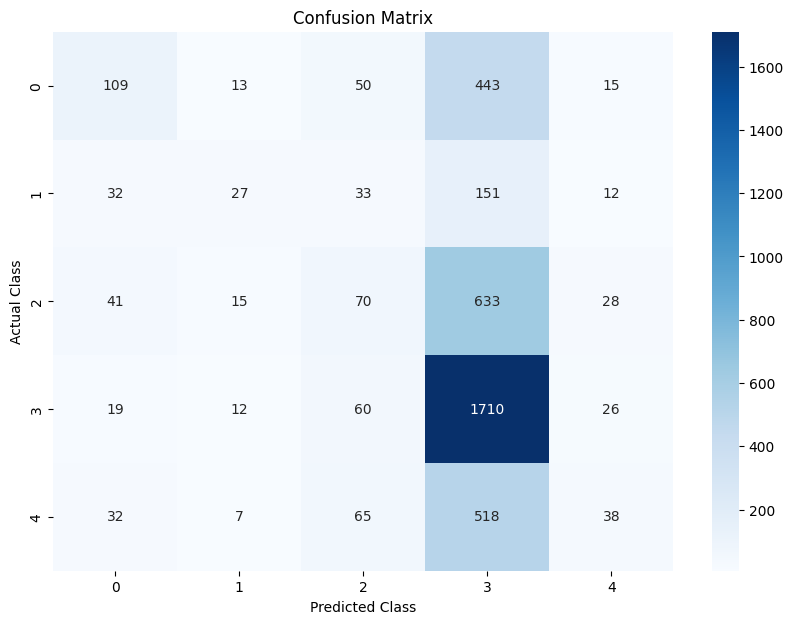

In [30]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_rf)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
labels = sorted(set(y_test) | set(y_pred))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Adding labels, title, and formatting
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

In [33]:
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.values.reshape(-1, 1))

X_train_cnn_lstm = np.expand_dims(X_train, axis=2)  # Adding a channel dimension
X_test_cnn_lstm = np.expand_dims(X_test, axis=2)

# Define the CNN-LSTM model
cnn_lstm_model = Sequential([
    # CNN for automatic feature extraction
    Input(shape=(X_train.shape[1], 1)),  # Input shape: (features, channels)
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # LSTM for sequential detection
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.4),

    # Fully connected layer for classification
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_model.fit(X_train_cnn_lstm, y_train_onehot, epochs=150, batch_size=64, validation_data=(X_test_cnn_lstm, y_test_onehot))

# Evaluate the model
cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test_cnn_lstm, y_test_onehot, verbose=0)
print(f"CNN-LSTM Test Accuracy: {cnn_lstm_accuracy:.2f}")


Epoch 1/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4209 - loss: 1.4665 - val_accuracy: 0.4393 - val_loss: 1.4046
Epoch 2/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4374 - loss: 1.4175 - val_accuracy: 0.4540 - val_loss: 1.3937
Epoch 3/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4455 - loss: 1.4012 - val_accuracy: 0.4525 - val_loss: 1.3823
Epoch 4/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4565 - loss: 1.3780 - val_accuracy: 0.4520 - val_loss: 1.3786
Epoch 5/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4517 - loss: 1.3846 - val_accuracy: 0.4530 - val_loss: 1.3803
Epoch 6/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4522 - loss: 1.3801 - val_accuracy: 0.4499 - val_loss: 1.3812
Epoch 7/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4483 - loss: 1.3805 - val_accuracy: 0.4513 - val_loss: 1.3844
Epoch 8/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4485 - loss: 1.3863 -

KeyboardInterrupt: 